In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import seaborn as sns
import time

from emd import emd
from kde.location_project.cmp import geodesic_dist
# from kde.location_project.kde_2d import kdnearest

sys.setrecursionlimit(10000)

%matplotlib inline
init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None # turn off SettingWithCopyWarning

np.random.seed(1234)
time_span = 'month'
n_visits = 20

# Geolocation Data - Twitter

NOTE: all of the results in the paper discussed B as fixed, but in this analysis A is fixed.

## Descriptive Statistics 

In [2]:
### OC
oc_directory = os.path.join("..", "data", "oc") 
oc = pd.read_csv(os.path.join(oc_directory, "visits_no_filter.csv"))
oc_deduped = pd.read_csv(os.path.join(oc_directory, "visits_deduped.csv"))
oc_mpp = pd.read_csv(os.path.join(oc_directory, "mpp_visits_month0a_month1b_n20.csv"))

print("Days:", oc['day_id'].nunique())
print("Accounts:", oc['user_id'].nunique())
print("Events: ", oc.shape[0], " (", round(oc.shape[0] / oc['user_id'].nunique(), 1), ")",sep="")
print("Visits: ", oc_deduped.shape[0], " (", round(oc_deduped.shape[0] / oc['user_id'].nunique(), 1), ")",sep="")
print("")
print("MPP DATA (at least {} visits in each of the first two {}s)".format(n_visits, time_span))
print("Users:", oc_mpp['uid'].nunique())
print("Visits: ", len(oc_mpp), " (", round(len(oc_mpp) / oc_mpp['uid'].nunique(), 1), ")",sep="")

Days: 240
Accounts: 103271
Events: 655917 (6.4)
Visits: 545697 (5.3)

MPP DATA (at least 20 visits in each of the first two months)
Users: 223
Visits: 28052 (125.8)


In [3]:
### NY
ny_directory = os.path.join("..", "data", "ny") 
ny = pd.read_csv(os.path.join(ny_directory, "visits_no_filter.csv"))
ny_deduped = pd.read_csv(os.path.join(ny_directory, "visits_deduped.csv"))
ny_mpp = pd.read_csv(os.path.join(ny_directory, "mpp_visits_month0a_month1b_n20.csv"))

print("Days:", ny['day_id'].nunique())
print("Accounts:", ny['user_id'].nunique())
print("Events: ", ny.shape[0], " (", round(ny.shape[0] / ny['user_id'].nunique(), 1), ")",sep="")
print("Visits: ", ny_deduped.shape[0], " (", round(ny_deduped.shape[0] / ny['user_id'].nunique(), 1), ")",sep="")
print("")
print("MPP DATA (at least {} visits in each of the first two {}s)".format(n_visits, time_span))
print("Users:", ny_mpp['uid'].nunique())
print("Visits: ", len(ny_mpp), " (", round(len(ny_mpp) / ny_mpp['uid'].nunique(), 1), ")",sep="")

Days: 239
Accounts: 194224
Events: 1162871 (6.0)
Visits: 989494 (5.1)

MPP DATA (at least 20 visits in each of the first two months)
Users: 184
Visits: 22936 (124.7)


## Example Plots

In [4]:
def calc_freqs(df):
    ### grid the population data for OC & count visits in each bin
    data = df.copy()
    data["lat_r"] = data.lat.round(3)
    data["lon_r"] = data.lon.round(3)
    freqs = (
        data.groupby(["lat_r", "lon_r"]).count().reset_index()[["lat_r", "lon_r", "event_id"]]
    )
    freqs.columns = ["lat_r", "lon_r", "freq"]
    return freqs


def get_user(mpp, uid, mark):
    out = mpp.copy()
    # out = out.drop_duplicates(subset=["location_id", "m"])
    return out.loc[(out.uid == uid) & (out.m == mark)].reset_index(drop=True)


def make_user_scatter_plot(mpp, uid, mark):
    user = get_user(mpp, uid, mark)
    return list(zip(user.lat, user.lon))

In [5]:
import branca.colormap as cm
from branca.element import Template, MacroElement
from collections import defaultdict
import folium
from folium.plugins import HeatMap, MarkerCluster


### https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; left: 20px; bottom: 40px;'>
     
<div class='legend-title'></div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:black;'></span>Month 1</li>
    <li><span style='background:red;'></span>Month 2</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 10px;
    width: 10px;
    -webkit-border-radius: 5px;
    -moz-border-radius: 5px;
    border-radius: 5px;
    margin-right: 5px;
    margin-left: 0;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""


def plot_heat_and_scatter(freqs, mpp, uid, loc, uidB=None, heat=True):
    if uidB is None:
        uidB = uid
    if heat:
        col = 'lightgreen'
        opacity = 0.8
    else:
        col = 'red'
        opacity = 0.75
    
    ### make the map
    if loc == 'oc':
        hmap = folium.Map(
            location=[33.68, -117.78],
            width='70%', 
            # width='60%',
            # height='95%',
            zoom_start=10, 
            zoom_control=False,
            tiles='CartoDB positron',
        )
    elif loc =='ny':
        hmap = folium.Map(
            location=[40.735, -73.99],
            width='70%', 
            # width='60%',
            # height='95%',
#             zoom_start=12.5,
            zoom_start=11,
            zoom_control=False,
            tiles='CartoDB positron',
        )
    
    ### make the heatmap
    if heat:
        steps = 20
        color_map = cm.linear.YlOrRd_09.scale(0, 1).to_step(steps)

        gradient_map = defaultdict(dict)
        for i in range(steps):
            gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)

        if loc == 'oc':
            heat = HeatMap( 
                data=list(zip(freqs['lat_r'], freqs['lon_r'], freqs['freq'])),
                min_opacity=0.2,
                max_val=float(freqs['freq'].max()),
                radius=20, 
                blur=15, 
                max_zoom=5, 
                gradient=gradient_map
            )
        
        if loc == 'ny':
            heat = HeatMap( 
                data=list(zip(freqs['lat_r'], freqs['lon_r'], freqs['freq'])),
                min_opacity=0.2,
                max_val=float(freqs['freq'].max()),
                radius=20, 
                blur=15, 
                max_zoom=5, 
                gradient=gradient_map
            )
        
        hmap.add_child(heat)
        hmap.add_child(color_map)

    ### make the scatters
    f = folium.map.FeatureGroup()
    for pt in make_user_scatter_plot(mpp, uid, 'a'):
        f.add_child(
            folium.vector_layers.CircleMarker(
                pt,
                radius=4,
                color=None,
                fill_color='black',
                fill_opacity=0.75)
        )

    for pt in make_user_scatter_plot(mpp, uidB, 'b'):
        f.add_child(
            folium.vector_layers.CircleMarker(
                pt,
                radius=4,
                color=None,
                fill_color=col,
                fill_opacity=opacity)
        )
    hmap.add_child(f)

    ### add legend
    macro = MacroElement()
    macro._template = Template(template)
    hmap.get_root().add_child(macro)

    return hmap

In [6]:
oc_freqs = calc_freqs(oc_deduped)
plot_heat_and_scatter(freqs=oc_freqs, mpp=oc_mpp, uid=1, loc='oc')

In [7]:
oc_freqs = calc_freqs(oc_deduped)
plot_heat_and_scatter(freqs=oc_freqs, mpp=oc_mpp, uid=2, loc='oc')

In [8]:
ny_freqs = calc_freqs(ny_deduped)
plot_heat_and_scatter(freqs=ny_freqs, mpp=ny_mpp, uid=3, loc='ny', heat=False)

# Land Parcel Data


All my datasets sit at: `/extra/mlichman0/all_data/`

The Twitter one is in: `/extra/mlichman0/all_data/event_data/twitter/`

There are two types of location assignment, parcel and grid. Both are in that folder. If we take the parcel assignment file for the Orange Country for example, it's in: `/extra/mlichman0/all_data/event_data/twitter/parcel_ass/oc/area_assigned.csv`

There's also a filtered version of it with minimum 5 days for users and 3 events per locations in that folder.

The format is:

`[event_id, user_id, location_id, lon, lat, epoch time, day_id, seconds_since_monday]`

You can probably ignore some of those :)

You should have access, so let me know if you don't and I'll fix it.

## Descriptive Stats

#### OC

In [9]:
oc_locs = oc_deduped.groupby('location_id')['event_id'].count()
oc_locs.describe()

count    32978.000000
mean        16.547304
std        448.090031
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      72290.000000
Name: event_id, dtype: float64

In [10]:
oc_locs_users = oc_deduped.groupby(['location_id'])['old_uid'].nunique()
oc_locs_users.describe()

count    32978.000000
mean         7.852204
std        198.567716
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      30874.000000
Name: old_uid, dtype: float64

#### NY

In [11]:
ny_locs = ny_deduped.groupby('location_id')['event_id'].count()
ny_locs.describe()

count    21312.000000
mean        46.428960
std        698.078537
min          1.000000
25%          1.000000
50%          4.000000
75%         16.000000
max      75760.000000
Name: event_id, dtype: float64

In [12]:
ny_locs_users = ny_deduped.groupby(['location_id'])['old_uid'].nunique()
ny_locs_users.describe()

count    21312.000000
mean        26.827140
std        319.935058
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max      25775.000000
Name: old_uid, dtype: float64

## Plots

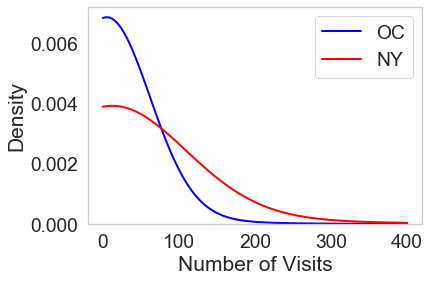

In [13]:
sns.set(font_scale=1.75)
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.kdeplot(
    oc_locs, 
    color = 'blue',
    lw=2,
    clip=(0,400),
    label='OC'
)
ax = sns.kdeplot(
    ny_locs, 
    color = 'red',
    lw=2,
    clip=(0,400),
    label='NY'
)
ax.set(ylabel="Density")
ax.set(xlabel="Number of Visits")
plt.show()

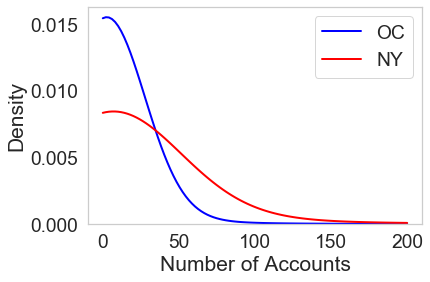

In [14]:
ax = sns.kdeplot(
    oc_locs_users, 
    color = 'blue',
    lw=2,
    clip=(0,200),
    label='OC'
)
ax = sns.kdeplot(
    ny_locs_users, 
    color = 'red',
    lw=2,
    clip=(0,200),
    label='NY'
)
ax.set(ylabel="Density")
ax.set(xlabel="Number of Accounts")
plt.show()

# Population Experiments - No Resampling

In [15]:
def population_scores(mpp):
    users = sorted(mpp['uid'].unique())  
    rslt = []
    
    for user_A in users[:2]:
        for user_B in users[:2]:
            tmp = {}
            try:
                ### get the data for the pair in question
                tmp['a'] = user_A
                tmp['b'] = user_B
                uA = get_user(mpp, user_A, 'a')
                uB = get_user(mpp, user_B, 'b')

                ### compute weights
                uA_wt_e = (uA['weight_event'] / sum(uA['weight_event'])).to_numpy()
                uA_wt_u = (uA['weight_user'] / sum(uA['weight_user'])).to_numpy()
                uB_wt_e = (uB['weight_event'] / sum(uB['weight_event'])).to_numpy()
                uB_wt_u = (uB['weight_user'] / sum(uB['weight_user'])).to_numpy()

                ### compute the distance matrix & IED scores
                dist = geodesic_dist(uA[['lat', 'lon']], uB[['lat', 'lon']])
                ied = dist.min(1)
                tmp['ied_med'] = np.median(ied)
                tmp['ied_mn'] = np.average(ied)
                tmp['ied_mn_wt_event'] = np.average(ied, weights=uA_wt_e)
                tmp['ied_mn_wt_user'] = np.average(ied, weights=uA_wt_u)

                ### compute variants of EMD
                tmp['emd'] = emd(distance="precomputed", D=dist)
                tmp['emd_wt_event'] = emd(
                    X_weights=uA_wt_e, Y_weights=uB_wt_e, distance="precomputed", D=dist
                )
                tmp['emd_wt_user'] = emd(
                    X_weights=uA_wt_u, Y_weights=uB_wt_u, distance="precomputed", D=dist
                )

                ### store it
                rslt.append(tmp)
            except:
                print(f"Error! A = {user_A}, B = {user_B}")
                continue
    
    return rslt

## OC
### Testing

In [16]:
# location weights based on number of visits
oc_wt_e = pd.DataFrame(oc_locs).reset_index().rename(columns={'event_id': 'weight'})
oc_wt_e['weight'] = 1 / oc_wt_e['weight']

# location weights based on number of unique users at location
oc_wt_u = pd.DataFrame(oc_locs_users).reset_index().rename(columns={'old_uid': 'weight'})
oc_wt_u['weight'] = 1 / oc_wt_u['weight']

# merge weights in to the point pattern data
oc_mpp = pd.merge(oc_mpp, oc_wt_e, on='location_id')
oc_mpp = pd.merge(oc_mpp, oc_wt_u, on='location_id', suffixes=('_event', '_user'))
oc_mpp.head()

,old_uid,uid,m,lon,lat,location_id,weight_event,weight_user
0,2554741.0,1,a,-117.83335,33.74851,546927.0,0.008264,0.011905
1,67150220.0,60,a,-117.83335,33.74851,546927.0,0.008264,0.011905
2,2554741.0,1,a,-117.67779,33.47102,517182.0,0.025641,0.250000
3,2554741.0,1,a,-117.67779,33.47102,517182.0,0.025641,0.250000
4,2554741.0,1,a,-117.67779,33.47102,517182.0,0.025641,0.250000


In [17]:
### perform the experiment
start = time.time()
oc_rslt = population_scores(oc_mpp)
end = time.time()
print("Elapsed time:", end - start, "s")

Elapsed time: 1.0493290424346924 s


### Result

In [18]:
oc_rslt = pd.read_csv(os.path.join(oc_directory, "population_score_func_vals.csv"))
oc_rslt.head()

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user
0,1,1,0.154327,1.109798,0.899208,0.405424,5.203970,4.480238,8.447241
1,1,2,19.399004,16.106065,14.226849,16.525475,26.537134,25.318528,31.016127
2,1,3,31.568979,25.179988,22.962231,28.489488,27.707953,24.773531,30.671102
3,1,4,23.133342,20.379347,19.991566,23.394986,28.031713,31.332737,37.205909
4,1,5,3.722272,4.592512,5.569412,4.784752,12.625797,12.583956,13.965850


## NY

### Testing

In [19]:
# location weights based on number of visits
ny_wt_e = pd.DataFrame(ny_locs).reset_index().rename(columns={'event_id': 'weight'})
ny_wt_e['weight'] = 1 / ny_wt_e['weight']

# location weights based on number of unique users at location
ny_wt_u = pd.DataFrame(ny_locs_users).reset_index().rename(columns={'old_uid': 'weight'})
ny_wt_u['weight'] = 1 / ny_wt_u['weight']

# merge weights in to the point pattern data
ny_mpp = pd.merge(ny_mpp, ny_wt_e, on='location_id')
ny_mpp = pd.merge(ny_mpp, ny_wt_u, on='location_id', suffixes=('_event', '_user'))
ny_mpp.head()

,old_uid,uid,m,lon,lat,location_id,weight_event,weight_user
0,420363.0,1,a,-74.00633,40.74349,25195.0,0.007194,0.022222
1,420363.0,1,a,-74.00625,40.74340,25195.0,0.007194,0.022222
2,420363.0,1,a,-74.00628,40.74371,25195.0,0.007194,0.022222
3,420363.0,1,a,-74.00617,40.74344,25195.0,0.007194,0.022222
4,420363.0,1,a,-74.00628,40.74371,25195.0,0.007194,0.022222


In [20]:
### perform the experiment
start = time.time()
ny_rslt = population_scores(ny_mpp)
end = time.time()
print("Elapsed time:", end - start, "s")

Elapsed time: 6.1912219524383545 s


### Result

In [21]:
ny_rslt = pd.read_csv(os.path.join(ny_directory, "population_score_func_vals_even_less_junk.csv"))
ny_rslt['same'] = (ny_rslt.a == ny_rslt.b).astype(bool)
ny_rslt.head()

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user,same
0,2,2,0.000000,0.000000,0.000000,0.000000,0.038907,0.133180,0.002110,True
1,2,3,4.206625,4.206625,4.206625,4.206625,6.076578,6.145157,6.178006,False
2,2,4,1.812073,1.812073,1.812073,1.812073,6.223725,7.123388,7.128614,False
3,2,6,2.115184,2.115184,2.115184,2.115184,6.057412,3.504397,3.747245,False
4,2,8,4.283570,4.283570,4.283570,4.283570,5.930094,5.604777,5.600928,False


In [22]:
ny_same = ny_rslt.loc[ny_rslt.a == ny_rslt.b, ]
ny_diff = ny_rslt.loc[ny_rslt.a != ny_rslt.b, ]


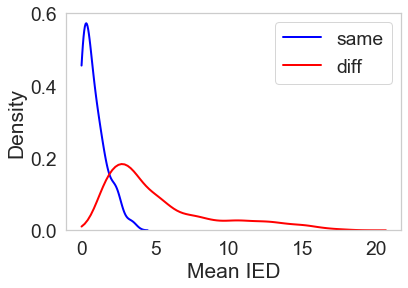

In [23]:
var = 'emd'
ax = sns.kdeplot(
    ny_same[var], 
    color = 'blue',
    lw=2,
    clip=(0,30),
    label='same'
)
ax = sns.kdeplot(
    ny_diff[var], 
    color = 'red',
    lw=2,
    clip=(0,30),
    label='diff'
)
ax.set(ylabel="Density")
ax.set(xlabel="Mean IED")
plt.show()

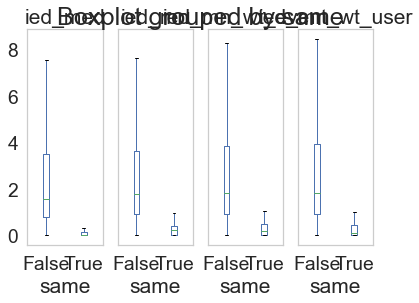

In [24]:
ny_rslt.boxplot(
    column=['ied_med', 'ied_mn', 'ied_mn_wt_event', 'ied_mn_wt_user'],
    layout=(1,4),
    by='same',
    grid=False,
    sym=''
)
plt.show()

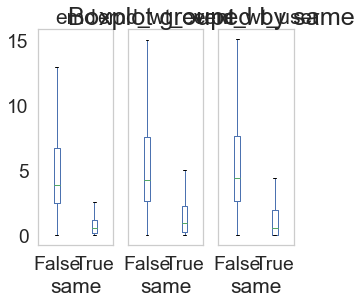

In [25]:
ny_rslt.boxplot(
    column=['emd', 'emd_wt_event', 'emd_wt_user'],
    layout=(1,4),
    by='same',
    grid=False,
    sym=''
)
plt.show()

# Evaluate the strength of evidence

### Test

In [26]:
from scipy import stats

def calc_slr(df, uA, uB, score):
    val = df.loc[(df.a == uA) & (df.b == uB), score].to_numpy()
    same = df.loc[
        (df.a == df.b) & ~(df.a.isin({uA, uB})), 
        score
    ].to_numpy()
    diff = df.loc[
        (df.a != df.b) & ~(df.a.isin({uA, uB})) & ~(df.b.isin({uA, uB})), 
        score
    ].to_numpy()
    
    kde_same = stats.gaussian_kde(same)
    kde_diff = stats.gaussian_kde(diff)
    
    return (kde_same.evaluate(val) / kde_diff.evaluate(val))[0]


def calc_cmp(df, uA, uB, score):
    val = df.loc[(df.a == uA) & (df.b == uB), score].to_numpy()
    diff = df.loc[
        (df.a != df.b) & ~(df.a.isin({uA, uB})) & ~(df.b.isin({uA, uB})), 
        score
    ].to_numpy()

    return sum(diff < val) / diff.shape[0]


In [27]:
# scores = [
#     'ied_med', 
#     'ied_mn', 
#     'ied_mn_wt_event', 
#     'ied_mn_wt_user', 
#     'emd', 
#     'emd_wt_event', 
#     'emd_wt_user'
# ]

# slr = []
# cmp = []

# start = time.time()
# for index, row in ny_rslt.iloc[:10,].iterrows():
#     tmp_slr = {'a': row['a'], 'b': row['b']}
#     tmp_cmp = {'a': row['a'], 'b': row['b']}
#     for s in scores:
#         tmp_slr[s] = calc_slr(ny_rslt, row['a'], row['b'], s)
#         tmp_cmp[s] = calc_cmp(ny_rslt, row['a'], row['b'], s)
#     slr.append(tmp_slr)
#     cmp.append(tmp_cmp)
    
# end = time.time()
# print(end - start)

# slr = pd.DataFrame.from_dict(slr)
# cmp = pd.DataFrame.from_dict(cmp)

## Analyze Results

In [28]:
from sklearn.metrics import roc_auc_score

def perf_measure(y_actual, y_hat):
    y_actual = list(y_actual)
    y_hat = list(y_hat)

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    
    return (format(round(tpr, 3), '.3f'), format(round(fpr, 3), '.3f'))


def calc_auc(rslt, score):
    return format(round(roc_auc_score(rslt['label'], rslt[score]), 3), '.3f')


def slr_classifier_performance_for_tex(rslt):
    print("& Weights & $\Delta$ &  TP@1  & FP@1  & AUC \\\\")
    print("\\hline")
#     print(
#         "& Med IED  & --      & ", 
#         "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_med'] > 1)), "&", 
#         calc_auc(rslt, 'ied_med'), "\\\\"
#     )
    print(
        "& Account & $\mean{D}_{min}$ & ",
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn_wt_user'] > 1)), "&", 
        calc_auc(rslt,'ied_mn_wt_user'), "\\\\"
    )
    print(
        "& Account & EMD    & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd_wt_user'] > 1)), "&", 
        calc_auc(rslt,'emd_wt_user'), "\\\\"
    )
    print(
        "& Uniform & $\mean{D}_{min}$ & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn'] > 1)), "&", 
        calc_auc(rslt,'ied_mn'), "\\\\"
    ) 
    print(
        "& Uniform & EMD     & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd'] > 1)), "&", 
        calc_auc(rslt,'emd'), "\\\\"
    )
    print(
        "& Visit   & $\mean{D}_{min}$ & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn_wt_event'] > 1)), "&", 
        calc_auc(rslt,'ied_mn_wt_event'), "\\\\"
    )
    print(
        "& Visit   & EMD      & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd_wt_event'] > 1)), "&", 
        calc_auc(rslt,'emd_wt_event'), "\\\\"
    )

    

def cmp_classifier_performance_for_tex(rslt):
    print("& $\Delta$ & Weights & TP@0.05  & TP@0.01 & AUC    ")
    print("\\hline")
#     print(
#         "& Med IED  & --      & ", 
#         "{0[0]}   & {0[1]}".format(perf_measure(~rslt['label'], rslt['ied_med'] < 0.05)), "  &",
#         "{0[0]}    & {0[1]}".format(perf_measure(~rslt['label'], rslt['ied_med'] < 0.01)), "   &",
#         calc_auc(rslt, 'ied_med'), "\\\\"
#     )
    print(
        "& Account & $\mean{D}_{min}$ & ",
        perf_measure(~rslt['label'], rslt['ied_mn_wt_user'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['ied_mn_wt_user'] < 0.01)[0], "  &",
        calc_auc(rslt,'ied_mn_wt_user'), "\\\\"
    )
    print(
        "& Account & EMD & ",
        perf_measure(~rslt['label'], rslt['emd_wt_user'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['emd_wt_user'] < 0.01)[0], "  &",
        calc_auc(rslt,'emd_wt_user'), "\\\\"
    )
    print(
        "& Uniform & $\mean{D}_{min}$ & ", 
        perf_measure(~rslt['label'], rslt['ied_mn'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['ied_mn'] < 0.01)[0], "  &",
        calc_auc(rslt,'ied_mn'), "\\\\"
    ) 
    print(
        "& Uniform & EMD & ", 
        perf_measure(~rslt['label'], rslt['emd'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['emd'] < 0.01)[0], "  &",
        calc_auc(rslt,'emd'), "\\\\"
    )
    print(
        "& Visit   & $\mean{D}_{min}$ & ", 
        perf_measure(~rslt['label'], rslt['ied_mn_wt_event'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['ied_mn_wt_event'] < 0.01)[0], "  &",
        calc_auc(rslt,'ied_mn_wt_event'), "\\\\"
    )
    print(
        "& Visit   & EMD & ", 
        perf_measure(~rslt['label'], rslt['emd_wt_event'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['emd_wt_event'] < 0.01)[0], "  &",
        calc_auc(rslt,'emd_wt_event'), "\\\\"
    )

## NY

In [29]:
"""
no qualifier: result on mpp_visits_month0a_month1b_n20
restricted_diff_src: select different src pairs with at least one location 
    in common with A
no_junk: removed accounts with > 90% of events in A OR B 
    (and at least one event in A & B at same location)
    occurring at the same set of prevalent locs (> 90% accounts)
even_less_junk: same as no_junk but with 50% filters on A & B
"""
slr = pd.read_csv(os.path.join(ny_directory, "slr_even_less_junk.csv"))
cmp = pd.read_csv(os.path.join(ny_directory, "cmp_population_even_less_junk.csv"))

# compute auc
print("----- SLR -----")
slr['label'] = (slr.a == slr.b).astype(bool)  # same-src has larger slr
slr_classifier_performance_for_tex(slr)

print("\n----- CMP -----")
cmp['label'] = (cmp.a != cmp.b).astype(bool)  # same-src has smaller cmp
cmp_classifier_performance_for_tex(cmp)

----- SLR -----
& Weights & $\Delta$ &  TP@1  & FP@1  & AUC \\
\hline
& Account & $\mean{D}_{min}$ &  0.842 & 0.178 & 0.926 \\
& Account & EMD    &  0.752 & 0.152 & 0.886 \\
& Uniform & $\mean{D}_{min}$ &  0.881 & 0.201 & 0.943 \\
& Uniform & EMD     &  0.871 & 0.136 & 0.948 \\
& Visit   & $\mean{D}_{min}$ &  0.842 & 0.209 & 0.912 \\
& Visit   & EMD      &  0.723 & 0.184 & 0.857 \\

----- CMP -----
& $\Delta$ & Weights & TP@0.05  & TP@0.01 & AUC    
\hline
& Account & $\mean{D}_{min}$ &  0.743   & 0.554   & 0.933 \\
& Account & EMD &  0.673   & 0.545   & 0.897 \\
& Uniform & $\mean{D}_{min}$ &  0.752   & 0.475   & 0.948 \\
& Uniform & EMD &  0.772   & 0.614   & 0.952 \\
& Visit   & $\mean{D}_{min}$ &  0.683   & 0.475   & 0.914 \\
& Visit   & EMD &  0.604   & 0.446   & 0.861 \\


### Subsample based on frequency of visits to popular locations

In [30]:
# statistics for visits & unique accts at locations
ny_loc_stats = pd.concat([ny_locs, ny_locs_users], axis=1).reset_index()
ny_loc_stats.columns = ['location_id', 'visits', 'accts']
ny_loc_stats['visits_pctile'] = ny_loc_stats['visits'].rank(pct=True)
ny_loc_stats['accts_pctile'] = ny_loc_stats['accts'].rank(pct=True)
ny_loc_stats = ny_loc_stats.sort_values('accts')
ny_loc_stats.loc[ny_loc_stats['accts_pctile'] > 0.9]

,location_id,visits,accts,visits_pctile,accts_pctile
7255,17876.0,124,35,0.950263,0.900479
10631,26611.0,39,35,0.858929,0.900479
1920,5090.0,153,35,0.960539,0.900479
10469,26316.0,42,35,0.866883,0.900479
14296,39852.0,46,35,0.875000,0.900479
...,...,...,...,...,...
19448,57066.0,15833,10839,0.999765,0.999812
47,68.0,17512,13828,0.999812,0.999859
5965,15684.0,26175,16383,0.999906,0.999906
12346,31198.0,23653,17766,0.999859,0.999953


In [31]:
# total number of events for each user/mark 
user_mark_tot = ny_mpp.groupby(['uid', 'm'])['lon'].count().to_frame().reset_index()

# total number of events for each user/mark/location
user_mark_loc_tot = ny_mpp.groupby(['uid', 'm', 'location_id'])['lon'].count().to_frame().reset_index()

# add in the total for the user/mark pair & calc percentage
user_mark_loc_tot = user_mark_loc_tot.merge(user_mark_tot, on=['uid', 'm'])
user_mark_loc_tot.columns = ['uid', 'm', 'location_id', 'n', 'tot']
user_mark_loc_tot['pct'] = user_mark_loc_tot['n'] / user_mark_loc_tot['tot']

# long -> wide by putting a & b info in same row
user_locs = user_mark_loc_tot.pivot_table(
    index=['uid', 'location_id'], 
    columns=['m'], 
    values=['n', 'tot', 'pct']
)
user_locs.columns = ['_'.join(col) for col in user_locs.columns]
user_locs = user_locs.reset_index()

# drop (user, location) pairs with no events in A, as they dont effect IED
# user_locs.dropna(subset=['n_a'], inplace=True)
# user_locs.drop(columns=['tot_b'], inplace=True)
# user_locs = user_locs.merge(
#     user_mark_tot.loc[user_mark_tot['m'] == 'b'],
#     on='uid'
# ).rename(columns={'lon': 'tot_b'}).drop(columns=['m'])
# user_locs = user_locs.fillna(0)

# join in population data on locations
user_locs = user_locs.merge(ny_loc_stats, on='location_id')
user_locs = user_locs.sort_values(['uid', 'accts'], ascending=[True, False])

# create a version of only rows with (user, location) pairs with both marks
user_locs_nomiss = user_locs.dropna()

user_locs.head()


,uid,location_id,n_a,n_b,pct_a,pct_b,tot_a,tot_b,visits,accts,visits_pctile,accts_pctile
0,1,3051.0,NaN,1.0,NaN,0.029412,NaN,34.0,8159,4234,0.999390,0.999343
33,1,25164.0,7.0,12.0,0.241379,0.352941,29.0,34.0,5736,4210,0.999155,0.999296
47,1,25188.0,1.0,NaN,0.034483,NaN,29.0,NaN,1710,1102,0.997560,0.997935
26,1,18885.0,NaN,1.0,NaN,0.029412,NaN,34.0,1386,1055,0.996950,0.997607
18,1,15681.0,1.0,NaN,0.034483,NaN,29.0,NaN,633,466,0.992234,0.993736


In [32]:
filt = user_locs_nomiss.loc[
    user_locs_nomiss.accts_pctile >= 0.90                          
].groupby('uid')['pct_a', 'pct_b'].sum()
print("Number of users with all events (A&B) at popular locs:", sum(filt.pct_a == filt.pct_b))

Number of users with all events (A&B) at popular locs: 28


In [33]:
junk_users = filt.loc[(filt.pct_a > 0.9) | (filt.pct_b > 0.9)].reset_index()
print(len(junk_users))
junk_users.head()

43


,uid,pct_a,pct_b
0,5,0.967742,1.000000
1,25,1.000000,1.000000
2,31,1.000000,1.000000
3,32,0.971175,0.943548
4,37,0.952381,0.916667


In [34]:
### remove these accounts
ny_scores_no_junk = ny_rslt.loc[~ny_rslt['a'].isin(junk_users['uid']) & ~ny_rslt['b'].isin(junk_users['uid'])]
# ny_scores_no_junk.to_csv(os.path.join(ny_directory, "population_score_func_vals_no_junk.csv"), index=False)


In [35]:
filt = user_locs_nomiss.loc[
    user_locs_nomiss.accts_pctile >= 0.90                          
].groupby('uid')['pct_a', 'pct_b'].sum()
junk_users = filt.loc[(filt.pct_a > 0.5) | (filt.pct_b > 0.5)].reset_index()
print(len(junk_users))

### remove these accounts
ny_scores_no_junk = ny_rslt.loc[~ny_rslt['a'].isin(junk_users['uid']) & ~ny_rslt['b'].isin(junk_users['uid'])]
# ny_scores_no_junk.to_csv(os.path.join(ny_directory, "population_score_func_vals_even_less_junk.csv"), index=False)

83


In [36]:
tmp = ny_mpp[~ny_mpp['uid'].isin(junk_users['uid'])]
print("MPP DATA")
print("Users:", tmp['uid'].nunique())
print("Visits: ", len(tmp), " (", round(len(tmp) / tmp['uid'].nunique(), 1), ")",sep="")


MPP DATA
Users: 101
Visits: 9927 (98.3)


### Investigate points that disagree on classification

In [37]:
culprits_ind = (
    (slr.label == True) & 
    (slr.emd >= 1) & 
    (slr.emd_wt_user < 1)
)
culprits = slr.loc[culprits_ind, 'a'].unique()
print(len(culprits))
print(culprits)

18
[  3  16  21  24  29  46  53  76 107 108 109 116 123 130 135 145 148 166]


In [38]:
slr.loc[culprits_ind] #.sort_values('emd_wt_user', ascending=False)

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user,label
1,3,3,0.118862,0.889040,0.460683,0.581836,3.644882,0.829496,0.738699,True
11,16,16,17.377006,11.162554,5.143544,7.124733,8.994288,0.355841,0.247235,True
15,21,21,0.838905,0.880011,1.048495,0.822336,4.901118,0.657474,0.683811,True
18,24,24,15.084353,7.547018,0.290412,0.463687,6.359843,0.281467,0.225736,True
22,29,29,17.334230,12.493545,8.553400,10.865881,22.192069,0.167958,0.689675,True
31,46,46,2.606306,1.695342,1.561419,0.756022,5.401458,0.953628,0.739259,True
36,53,53,0.872830,2.592459,6.846754,7.278856,3.408352,0.586377,0.559252,True
50,76,76,11.231015,7.711378,3.142175,4.632520,3.304701,0.510934,0.425932,True
66,107,107,10.226905,5.204212,4.463041,6.288116,1.139953,0.365570,0.114184,True
67,108,108,17.015814,7.932933,5.871659,6.364803,1.617047,0.173297,0.229326,True


In [39]:
tmp = user_locs_nomiss.loc[user_locs_nomiss['uid'].isin(culprits),]
print(
    sum(tmp.groupby('uid')['pct_a'].sum() >= 0.5), 
    "/", len(culprits), "=", 
    round(sum(tmp.groupby('uid')['pct_a'].sum() >= 0.5) / len(culprits) * 100, 2), "%"
)
tmp.groupby('uid')['pct_a'].sum() >= 0.5

5 / 18 = 27.78 %


uid
3      False
16      True
21     False
24     False
29      True
46     False
53     False
76      True
107    False
108     True
109    False
116    False
123    False
130    False
135    False
145     True
148    False
166    False
Name: pct_a, dtype: bool

In [40]:
# 173 is interesting. first discovered the phenomenon 
# 29 is odd
uA = uB = 88
# uB = 125
plot_heat_and_scatter(
    freqs=ny_freqs, mpp=ny_mpp, uid=uA, uidB=uB, loc='ny', heat=True
)


In [41]:
user_locs.loc[user_locs.uid == uA].sort_values(['n_a', 'n_b'], ascending=False)

,uid,location_id,n_a,n_b,pct_a,pct_b,tot_a,tot_b,visits,accts,visits_pctile,accts_pctile
1475,88,48794.0,7.0,NaN,0.291667,NaN,24.0,NaN,134,93,0.954533,0.963143
2596,88,39787.0,3.0,1.0,0.125000,0.043478,24.0,23.0,103,64,0.939940,0.944867
827,88,68.0,2.0,3.0,0.083333,0.130435,24.0,23.0,17512,13828,0.999812,0.999859
131,88,22038.0,2.0,2.0,0.083333,0.086957,24.0,23.0,6057,4489,0.999202,0.999390
13,88,3051.0,1.0,NaN,0.041667,NaN,24.0,NaN,8159,4234,0.999390,0.999343
288,88,31099.0,1.0,NaN,0.041667,NaN,24.0,NaN,3799,2976,0.998827,0.999108
1380,88,39831.0,1.0,NaN,0.041667,NaN,24.0,NaN,1175,788,0.996199,0.996176
2584,88,8397.0,1.0,NaN,0.041667,NaN,24.0,NaN,195,172,0.969923,0.980950
2588,88,9214.0,1.0,NaN,0.041667,NaN,24.0,NaN,170,152,0.965114,0.978158
1121,88,17274.0,1.0,NaN,0.041667,NaN,24.0,NaN,146,122,0.958122,0.972293


In [42]:
user_locs.loc[user_locs.uid == uB].sort_values(['n_a', 'n_b'], ascending=False)

,uid,location_id,n_a,n_b,pct_a,pct_b,tot_a,tot_b,visits,accts,visits_pctile,accts_pctile
1475,88,48794.0,7.0,NaN,0.291667,NaN,24.0,NaN,134,93,0.954533,0.963143
2596,88,39787.0,3.0,1.0,0.125000,0.043478,24.0,23.0,103,64,0.939940,0.944867
827,88,68.0,2.0,3.0,0.083333,0.130435,24.0,23.0,17512,13828,0.999812,0.999859
131,88,22038.0,2.0,2.0,0.083333,0.086957,24.0,23.0,6057,4489,0.999202,0.999390
13,88,3051.0,1.0,NaN,0.041667,NaN,24.0,NaN,8159,4234,0.999390,0.999343
288,88,31099.0,1.0,NaN,0.041667,NaN,24.0,NaN,3799,2976,0.998827,0.999108
1380,88,39831.0,1.0,NaN,0.041667,NaN,24.0,NaN,1175,788,0.996199,0.996176
2584,88,8397.0,1.0,NaN,0.041667,NaN,24.0,NaN,195,172,0.969923,0.980950
2588,88,9214.0,1.0,NaN,0.041667,NaN,24.0,NaN,170,152,0.965114,0.978158
1121,88,17274.0,1.0,NaN,0.041667,NaN,24.0,NaN,146,122,0.958122,0.972293


## OC

In [43]:
slr = pd.read_csv(os.path.join(oc_directory, "slr_even_less_junk.csv"))
cmp = pd.read_csv(os.path.join(oc_directory, "cmp_population_even_less_junk.csv"))

# compute auc
print("----- SLR -----")
slr['label'] = (slr.a == slr.b).astype(bool)  # same-src has larger slr
slr_classifier_performance_for_tex(slr)

print("\n----- CMP -----")
cmp['label'] = (cmp.a != cmp.b).astype(bool)  # same-src has smaller cmp
cmp_classifier_performance_for_tex(cmp)

----- SLR -----
& Weights & $\Delta$ &  TP@1  & FP@1  & AUC \\
\hline
& Account & $\mean{D}_{min}$ &  0.952 & 0.054 & 0.987 \\
& Account & EMD    &  0.890 & 0.047 & 0.970 \\
& Uniform & $\mean{D}_{min}$ &  0.945 & 0.065 & 0.983 \\
& Uniform & EMD     &  0.945 & 0.058 & 0.979 \\
& Visit   & $\mean{D}_{min}$ &  0.918 & 0.103 & 0.962 \\
& Visit   & EMD      &  0.870 & 0.103 & 0.938 \\

----- CMP -----
& $\Delta$ & Weights & TP@0.05  & TP@0.01 & AUC    
\hline
& Account & $\mean{D}_{min}$ &  0.952   & 0.863   & 0.989 \\
& Account & EMD &  0.897   & 0.795   & 0.976 \\
& Uniform & $\mean{D}_{min}$ &  0.932   & 0.740   & 0.987 \\
& Uniform & EMD &  0.938   & 0.767   & 0.984 \\
& Visit   & $\mean{D}_{min}$ &  0.836   & 0.664   & 0.968 \\
& Visit   & EMD &  0.801   & 0.616   & 0.946 \\


In [44]:
slr.describe()

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user
count,5146.00000,5146.000000,5.146000e+03,5.146000e+03,5146.000000,5.146000e+03,5.146000e+03,5.146000e+03,5.146000e+03
mean,118.81131,118.791683,3.391333e+00,1.497052e+00,1.179814,1.817250e+00,3.277026e+00,1.719183e+00,2.773674e+00
std,62.29300,61.889727,1.926470e+01,7.023079e+00,4.544632,9.248253e+00,2.163666e+01,1.024377e+01,1.629033e+01
min,1.00000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,7.189222e-65,9.521765e-183
25%,67.00000,67.000000,0.000000e+00,1.993406e-201,0.000041,1.533960e-190,1.091742e-38,3.458648e-02,1.251761e-03
50%,123.00000,123.000000,1.586711e-159,1.022771e-22,0.043859,3.550074e-18,2.991624e-05,1.589593e-01,5.630416e-02
75%,170.00000,170.000000,7.360835e-04,1.174090e-01,0.295863,1.168817e-01,1.737968e-01,2.736489e-01,1.730184e-01
max,223.00000,223.000000,1.236478e+02,5.685027e+01,36.364048,6.429110e+01,2.571894e+02,1.732173e+02,1.611746e+02


### Subsample based on frequency of visits to popular locations

In [45]:
# statistics for visits & unique accts at locations
oc_loc_stats = pd.concat([oc_locs, oc_locs_users], axis=1).reset_index()
oc_loc_stats.columns = ['location_id', 'visits', 'accts']
oc_loc_stats['visits_pctile'] = oc_loc_stats['visits'].rank(pct=True)
oc_loc_stats['accts_pctile'] = oc_loc_stats['accts'].rank(pct=True)
oc_loc_stats = oc_loc_stats.sort_values('accts')
oc_loc_stats.loc[oc_loc_stats['accts_pctile'] > 0.99]

,location_id,visits,accts,visits_pctile,accts_pctile
23965,463975.0,89,79,0.979774,0.990008
23798,459873.0,134,79,0.987097,0.990008
7672,125634.0,100,79,0.982306,0.990008
8447,145480.0,102,79,0.982746,0.990008
14474,275060.0,107,80,0.983489,0.990115
...,...,...,...,...,...
7160,112781.0,3857,2632,0.999697,0.999879
4852,81607.0,5266,3040,0.999879,0.999909
758,11707.0,7761,4764,0.999939,0.999939
3683,62149.0,30910,15404,0.999970,0.999970


In [46]:
# total number of events for each user/mark 
user_mark_tot = oc_mpp.groupby(['uid', 'm'])['lon'].count().to_frame().reset_index()

# total number of events for each user/mark/location
user_mark_loc_tot = oc_mpp.groupby(['uid', 'm', 'location_id'])['lon'].count().to_frame().reset_index()

# add in the total for the user/mark pair & calc percentage
user_mark_loc_tot = user_mark_loc_tot.merge(user_mark_tot, on=['uid', 'm'])
user_mark_loc_tot.columns = ['uid', 'm', 'location_id', 'n', 'tot']
user_mark_loc_tot['pct'] = user_mark_loc_tot['n'] / user_mark_loc_tot['tot']

# long -> wide by putting a & b info in same row
user_locs = user_mark_loc_tot.pivot_table(
    index=['uid', 'location_id'], 
    columns=['m'], 
    values=['n', 'tot', 'pct']
)
user_locs.columns = ['_'.join(col) for col in user_locs.columns]
user_locs = user_locs.reset_index()

# drop (user, location) pairs with no events in A, as they dont effect IED
# user_locs.dropna(subset=['n_a'], inplace=True)
# user_locs.drop(columns=['tot_b'], inplace=True)
# user_locs = user_locs.merge(
#     user_mark_tot.loc[user_mark_tot['m'] == 'b'],
#     on='uid'
# ).rename(columns={'lon': 'tot_b'}).drop(columns=['m'])
# user_locs = user_locs.fillna(0)

# join in population data on locations
user_locs = user_locs.merge(oc_loc_stats, on='location_id')
user_locs = user_locs.sort_values(['uid', 'accts'], ascending=[True, False])

# create a version of only rows with (user, location) pairs with both marks
user_locs_nomiss = user_locs.dropna()

In [47]:
filt = user_locs_nomiss.loc[
    user_locs_nomiss.accts_pctile >= 0.90                          
].groupby('uid')['pct_a', 'pct_b'].sum()
print("Number of users with all events (A&B) at popular locs:", sum(filt.pct_a == filt.pct_b))

Number of users with all events (A&B) at popular locs: 12


In [48]:
junk_users = filt.loc[(filt.pct_a > 0.9) | (filt.pct_b > 0.9)].reset_index()
print(len(junk_users))
junk_users.head()

37


,uid,pct_a,pct_b
0,10,0.973684,0.875000
1,12,0.981818,1.000000
2,13,0.976190,0.675676
3,15,1.000000,1.000000
4,16,0.947368,0.950000


In [49]:
### remove these accounts
oc_scores_no_junk = oc_rslt.loc[
    ~oc_rslt['a'].isin(junk_users['uid']) & ~oc_rslt['b'].isin(junk_users['uid'])
]
# oc_scores_no_junk.to_csv(os.path.join(oc_directory, "population_score_func_vals_no_junk.csv"), index=False)


In [50]:
filt = user_locs_nomiss.loc[
    user_locs_nomiss.accts_pctile >= 0.90                          
].groupby('uid')['pct_a', 'pct_b'].sum()
junk_users = filt.loc[(filt.pct_a > 0.5) | (filt.pct_b > 0.5)].reset_index()
print(len(junk_users))

### remove these accounts
oc_scores_no_junk = oc_rslt.loc[
    ~oc_rslt['a'].isin(junk_users['uid']) & ~oc_rslt['b'].isin(junk_users['uid'])
]
# oc_scores_no_junk.to_csv(os.path.join(oc_directory, "population_score_func_vals_even_less_junk.csv"), index=False)


77


In [51]:
tmp = oc_mpp[~oc_mpp['uid'].isin(junk_users['uid'])]
print("MPP DATA")
print("Users:", tmp['uid'].nunique())
print("Visits: ", len(tmp), " (", round(len(tmp) / tmp['uid'].nunique(), 1), ")",sep="")


MPP DATA
Users: 146
Visits: 15170 (103.9)


### Investigate points with large differences

In [52]:
culprits_ind = (
    (slr.label == True) & 
    (slr.emd >= 1) & 
    (slr.emd_wt_user < 1)
)
culprits = slr.loc[culprits_ind, 'a'].unique()
print(len(culprits))
print(culprits)

11
[  1   4   6   8  19  47  49  56  65 101 133]


In [53]:
slr.loc[culprits_ind] #.sort_values('emd_wt_user', ascending=False)

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user,label
0,1,1,84.620024,14.245157,18.074933,41.684863,2.712470,6.987259,0.407894,True
2,4,4,121.781964,0.654716,0.059200,0.107090,8.414359,0.191289,0.284784,True
4,6,6,10.808014,4.334837,9.154024,4.285679,2.558402,0.199702,0.316292,True
6,8,8,33.495824,9.704841,7.752443,1.979753,7.398265,5.176334,0.771830,True
10,19,19,2.599947,4.996089,3.000210,4.603483,1.219212,4.912016,0.125472,True
24,47,47,121.964971,21.327620,29.267951,62.784747,6.585016,0.192846,0.422247,True
25,49,49,122.884731,38.410989,0.228767,1.493690,4.062976,0.201748,0.558181,True
30,56,56,122.747630,0.004703,0.176567,0.068256,3.945161,1.105778,0.452540,True
35,65,65,121.533424,44.745474,28.439459,61.748571,1.397222,7.828721,0.592661,True
56,101,101,2.560670,10.984715,4.360423,0.908029,24.070878,0.397483,0.434237,True


In [54]:
cmp.loc[culprits_ind]

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user,label
0,1,1,0.000527,0.010010,0.005220,0.001964,0.029646,0.017529,0.122510,False
2,4,4,0.000000,0.074042,0.296983,0.192241,0.011925,0.395977,0.178352,False
4,6,6,0.004646,0.031178,0.015900,0.018439,0.030843,0.278400,0.168870,False
6,8,8,0.002203,0.015134,0.019397,0.031561,0.013985,0.025287,0.051580,False
10,19,19,0.013075,0.028400,0.047031,0.017768,0.049856,0.026724,0.223420,False
24,47,47,0.000000,0.006274,0.000814,0.000048,0.015469,0.392289,0.112931,False
25,49,49,0.000000,0.002011,0.228352,0.038075,0.021983,0.318918,0.068295,False
30,56,56,0.000000,0.158525,0.249042,0.306226,0.022174,0.092241,0.097270,False
35,65,65,0.000000,0.001149,0.001006,0.000048,0.045785,0.015757,0.065421,False
56,101,101,0.013266,0.013266,0.033477,0.050287,0.004262,0.168774,0.105939,False


In [55]:
tmp = user_locs_nomiss.loc[user_locs_nomiss['uid'].isin(culprits),]
print(
    sum(tmp.groupby('uid')['pct_a'].sum() >= 0.5), 
    "/", len(culprits), "=", 
    round(sum(tmp.groupby('uid')['pct_a'].sum() >= 0.5) / len(culprits) * 100, 2), "%"
)
tmp.groupby('uid')['pct_a'].sum() >= 0.5

6 / 11 = 54.55 %


uid
1      False
4       True
6      False
8      False
19     False
47      True
49      True
56      True
65      True
101    False
133     True
Name: pct_a, dtype: bool

In [56]:
# 101 fits the tourist profile
# 5 Disneyland + shopping
uA = uB = 101
plot_heat_and_scatter(
    freqs=oc_freqs, mpp=oc_mpp, uid=uA, uidB=uB, loc='oc', heat=False
)

In [57]:
user_locs.loc[user_locs.uid == uA].sort_values(['n_a', 'n_b'], ascending=False)

,uid,location_id,n_a,n_b,pct_a,pct_b,tot_a,tot_b,visits,accts,visits_pctile,accts_pctile
83,101,61905.0,8.0,6.0,0.25000,0.214286,32.0,28.0,72290,30874,1.000000,1.000000
1926,101,556445.0,3.0,NaN,0.09375,NaN,32.0,NaN,3908,2379,0.999727,0.999833
125,101,62149.0,2.0,1.0,0.06250,0.035714,32.0,28.0,30910,15404,0.999970,0.999970
1167,101,95062.0,2.0,NaN,0.06250,NaN,32.0,NaN,41,34,0.950300,0.974544
713,101,35677.0,1.0,1.0,0.03125,0.035714,32.0,28.0,930,694,0.998393,0.999121
451,101,581063.0,1.0,1.0,0.03125,0.035714,32.0,28.0,1009,564,0.998757,0.998878
3591,101,98083.0,1.0,1.0,0.03125,0.035714,32.0,28.0,17,9,0.892701,0.912426
741,101,12340.0,1.0,NaN,0.03125,NaN,32.0,NaN,3766,2179,0.999636,0.999727
232,101,436568.0,1.0,NaN,0.03125,NaN,32.0,NaN,982,641,0.998696,0.998999
1128,101,97931.0,1.0,NaN,0.03125,NaN,32.0,NaN,1028,515,0.998848,0.998726


# Changes to denominator of SLR - not viable

In [58]:
def get_diff_src_set(scores, mpp, uA, uB):
    uA_locs = mpp.loc[
        (mpp['uid'] == uA) & (mpp['m'] == 'a'), 'location_id'
    ].unique()
    samp_sp = mpp.loc[
        ~mpp.uid.isin({uA, uB}) & mpp.location_id.isin(uA_locs), 'uid'
    ].unique() 
    return scores.loc[
        (
            (scores.a != scores.b)
            & ~(scores['a'].isin({uA, uB})) 
            & ~(scores['b'].isin({uA, uB})) 
            & (scores['a'].isin(samp_sp) | scores['b'].isin(samp_sp))
        ),
    ]

def calc_slr(df, uA, uB, score, diff=None, val=None):
    if val is None:
        val = df.loc[(df.a == uA) & (df.b == uB), score].to_numpy()
    same = df.loc[
        (df.a == df.b) & ~(df.a.isin({uA, uB})), 
        score
    ].to_numpy()
    if diff is None:
        diff = df.loc[
            (df.a != df.b) & ~(df.a.isin({uA, uB})) & ~(df.b.isin({uA, uB})), 
            score
        ].to_numpy()
    else:
        diff = diff[score].to_numpy()
    
    kde_same = stats.gaussian_kde(same)
    kde_diff = stats.gaussian_kde(diff)
    
    return (kde_same.evaluate(val) / kde_diff.evaluate(val))[0]


def calc_cmp(df, uA, uB, score, diff=None, val=None):
    if val is None:
        val = df.loc[(df.a == uA) & (df.b == uB), score].to_numpy()
    if diff is None:
        diff = df.loc[
            (df.a != df.b) & ~(df.a.isin({uA, uB})) & ~(df.b.isin({uA, uB})), 
            score
        ].to_numpy()
    else:
        diff = diff[score].to_numpy()
        
    return sum(diff < val) / diff.shape[0]

uA = uB = 1
# uB = 2
d = get_diff_src_set(oc_rslt, oc_mpp, uA, uB)
print("SLR:", calc_slr(oc_rslt, uA, uB, 'ied_med', diff=d))
print("CMP:", calc_cmp(oc_rslt, uA, uB, 'ied_med', diff=d))


SLR: 53.03556907876328
CMP: 0.004208754208754209


# Disneyland Problem

User 10 is a great example of this, but is now held-out of the data as a "junk" user. Repeat the analysis.

In [59]:
u = 10
u10_slr = {}
u10_cmp = {}

scores = ["ied_med", "ied_mn", "ied_mn_wt_event", "ied_mn_wt_user", "emd", "emd_wt_event", "emd_wt_user"]

for s in scores:
    v = oc_rslt.loc[(oc_rslt['a'] == u) & (oc_rslt['b'] == u), s].to_numpy()[0]
    u10_slr[s] = calc_slr(oc_scores_no_junk, u, u, s, val=v)
    u10_cmp[s] = calc_cmp(oc_scores_no_junk, u, u, s, val=v)

pd.DataFrame.from_dict([u10_slr, u10_cmp])

,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user
0,122.792721,51.653549,27.916573,38.623836,191.756202,0.896915,0.478418
1,0.000000,0.000000,0.001275,0.002267,0.000000,0.107700,0.118847


In [60]:
plot_heat_and_scatter(
    freqs=oc_freqs, mpp=oc_mpp, uid=10, uidB=10, loc='oc', heat=False
)